Proyecto Regresion Logistica

Configuracion y carga de datos

In [200]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt 

import json
from pickle import dump

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import accuracy_score

import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_columns', None)


RANDOM_STATE = 16
pd.set_option('display.max_columns', 200)

In [201]:
url = "https://storage.googleapis.com/breathecode/project-files/bank-marketing-campaign-data.csv"
df = pd.read_csv(url, sep=';')

print('El dataframe contiene {} lineas y {} features.'.format(len(df), df.shape[1]))
df.head(3)

El dataframe contiene 41188 lineas y 21 features.


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Chequeo de esquema y target

In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [203]:
df.isna().sum()[df.isna().sum()>0]

Series([], dtype: int64)

In [204]:
nulls = df.isna().mean().sort_values(ascending=False)
dups = df.duplicated().sum()
print("Duplicados:", dups)
nulls.head(10)

Duplicados: 12


age            0.0
job            0.0
marital        0.0
education      0.0
default        0.0
housing        0.0
loan           0.0
contact        0.0
month          0.0
day_of_week    0.0
dtype: float64

**Revisar estructura del dataset**

Entender rangos, outliers potenciales y categorias

In [205]:
df.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [206]:
df_enc = df.copy()

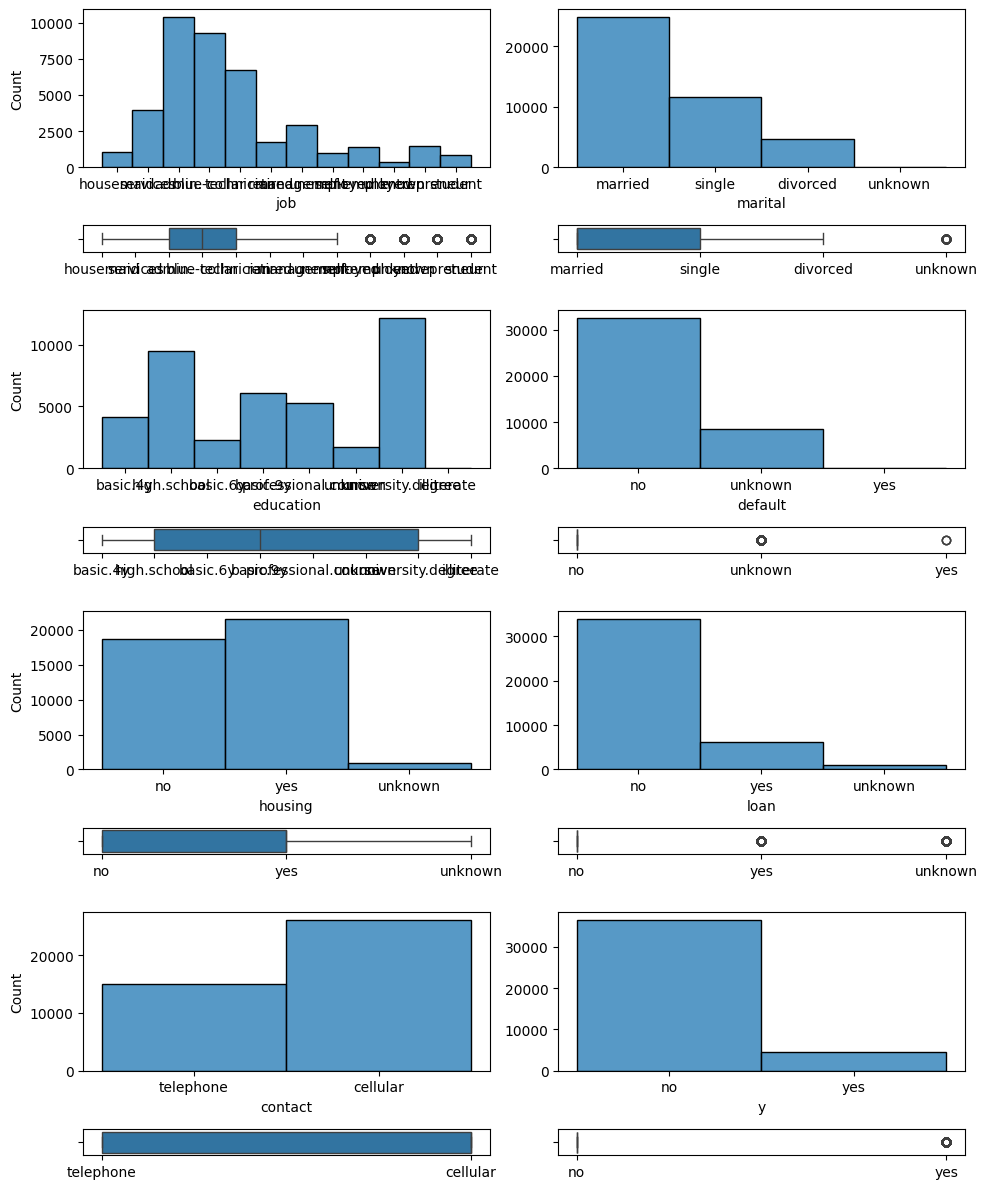

In [207]:
fig, ax = plt.subplots(8, 2, figsize=(10, 12), gridspec_kw={'height_ratios': [6, 1, 6, 1, 6, 1, 6, 1]})

# Graficos de la 1era fila 
sns.histplot(ax = ax[0,0], data = df_enc, x='job')
sns.boxplot(ax = ax[1,0], data = df_enc, x='job').set(xlabel = None)
sns.histplot(ax = ax[0,1], data = df_enc, x='marital').set(ylabel = None)
sns.boxplot(ax = ax[1,1], data = df_enc, x='marital').set(xlabel = None)

# Graficos de la 2da fila
sns.histplot(ax = ax[2,0], data = df_enc, x='education')
sns.boxplot(ax = ax[3,0], data = df_enc, x='education').set(xlabel = None)
sns.histplot(ax = ax[2,1], data = df_enc, x='default').set(ylabel = None)
sns.boxplot(ax = ax[3,1], data = df_enc, x='default').set(xlabel = None)

# Graficos de la 3era fila
sns.histplot(ax = ax[4,0], data = df_enc, x='housing')
sns.boxplot(ax = ax[5,0], data = df_enc, x='housing').set(xlabel = None)
sns.histplot(ax = ax[4,1], data = df_enc, x='loan').set(ylabel = None)
sns.boxplot(ax = ax[5,1], data = df_enc, x='loan').set(xlabel = None)

# Graficos de la 4ta fila
sns.histplot(ax = ax[6,0], data = df_enc, x='contact')
sns.boxplot(ax = ax[7,0], data = df_enc, x='contact').set(xlabel = None)
sns.histplot(ax = ax[6,1], data = df_enc, x='y').set(ylabel = None)
sns.boxplot(ax = ax[7,1], data = df_enc, x='y').set(xlabel = None)

plt.tight_layout()
plt.show()

In [208]:
num_cols = df_enc.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df_enc.select_dtypes(include=['object']).columns

print("Numéricas:", list(num_cols))
print("Categóricas:", list(cat_cols))

Numéricas: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Categóricas: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']


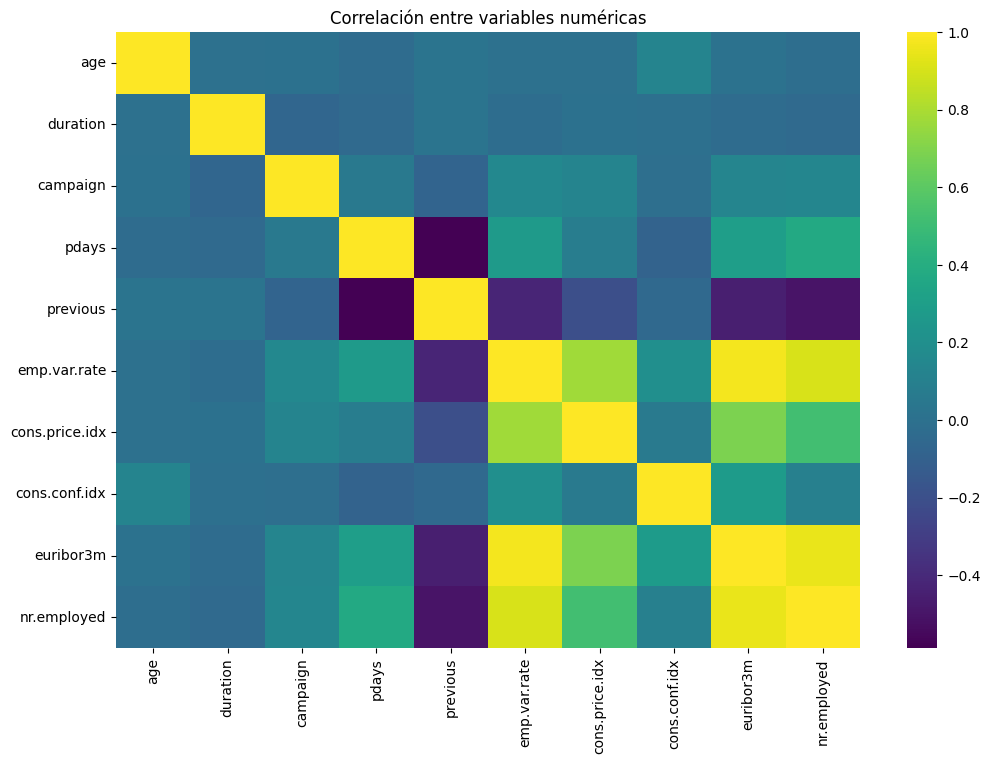

In [209]:
plt.figure(figsize=(12,8))
sns.heatmap(df_enc[num_cols].corr(), annot=False, cmap='viridis')
plt.title("Correlación entre variables numéricas")
plt.show()

In [210]:
df_enc.describe().round(2)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00
mean,40.02,258.29,2.57,962.48,0.17,0.08,93.58,-40.50,3.62,5167.04
std,10.42,259.28,2.77,186.91,0.49,1.57,0.58,4.63,1.73,72.25
min,17.00,0.00,1.00,0.00,0.00,-3.40,92.20,-50.80,0.63,4963.60
25%,32.00,102.00,1.00,999.00,0.00,-1.80,93.08,-42.70,1.34,5099.10
50%,38.00,180.00,2.00,999.00,0.00,1.10,93.75,-41.80,4.86,5191.00
75%,47.00,319.00,3.00,999.00,0.00,1.40,93.99,-36.40,4.96,5228.10
max,98.00,4918.00,56.00,999.00,7.00,1.40,94.77,-26.90,5.04,5228.10


**Deteccion de variables numericas vs categoricas**

**Frecuencias de categorias para verificar cuales son atipicas y decidir si agruparlas**

IndexError: index 2 is out of bounds for axis 0 with size 2

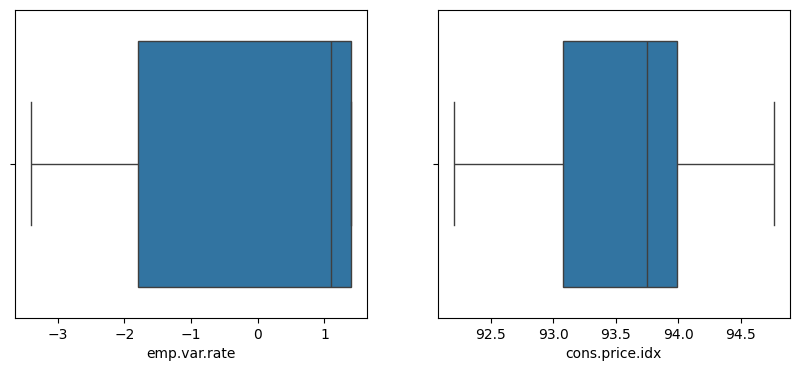

In [211]:
continuos_f = list(df_enc.select_dtypes('float64'))

fig, ax = plt.subplots(1,2, figsize=(10, 4))

col=0
for each in continuos_f:
    sns.boxplot(ax = ax[col], data = df_enc, x=each)
    col += 1

plt.tight_layout()
plt.show()

***Crear copia sin outliers***

In [ ]:
df_enc_no = df_enc.copy()

**Funcion que devuelve el dataframe sin los outliers y los limites de los features**

In [ ]:
def remove_outliers(x, feature_name, allow_neg=True):
    q1, q3 = x.quantile([0.25, 0.75])
    iqr = q3 - q1
    upper_lim = q3 + (iqr*1.5)
    lower_lim = q1 - (iqr*1.5) if allow_neg else max(0, q1 - (iqr * 1.5))

    x = x.apply(lambda x: upper_lim if (x > upper_lim) else (lower_lim if (x < lower_lim) else x))

    filename = f'../data/interim/outliers_lims_{feature_name}.json'
    json.dump({'upper_lim': upper_lim, 'lower_lim': lower_lim}, open(filename, 'w'))

    return x

In [ ]:
f_outliers_with_neg = []
f_outliers_no_neg = []

for each in continuos_f:
    if df_enc[each].min() < 0:
        f_outliers_with_neg.append(each)
    f_outliers_no_neg.append(each)

for feature in f_outliers_with_neg:
    df_enc_no[feature] = remove_outliers(df_enc_no[feature], feature)

for feature in f_outliers_no_neg:
    df_enc_no[feature] = remove_outliers(df_enc_no[feature], feature, allow_neg=False)

In [ ]:
for col in cat_cols:
    print(f"Columna: {col}")
    print(df[col].value_counts(normalize=True).head())

Columna: job
job
admin.         0.253035
blue-collar    0.224677
technician     0.163713
services       0.096363
management     0.070992
Name: proportion, dtype: float64
Columna: marital
marital
married     0.605225
single      0.280859
divorced    0.111974
unknown     0.001942
Name: proportion, dtype: float64
Columna: education
education
university.degree      0.295426
high.school            0.231014
basic.9y               0.146766
professional.course    0.127294
basic.4y               0.101389
Name: proportion, dtype: float64
Columna: default
default
no         0.791201
unknown    0.208726
yes        0.000073
Name: proportion, dtype: float64
Columna: housing
housing
yes        0.523842
no         0.452122
unknown    0.024036
Name: proportion, dtype: float64
Columna: loan
loan
no         0.824269
yes        0.151695
unknown    0.024036
Name: proportion, dtype: float64
Columna: contact
contact
cellular     0.634748
telephone    0.365252
Name: proportion, dtype: float64
Columna: month
m

**Analizar variable objetivo**

verificar el desbalance en las clases y entender si la logistica simple puede resultar en una accuracy engañosa

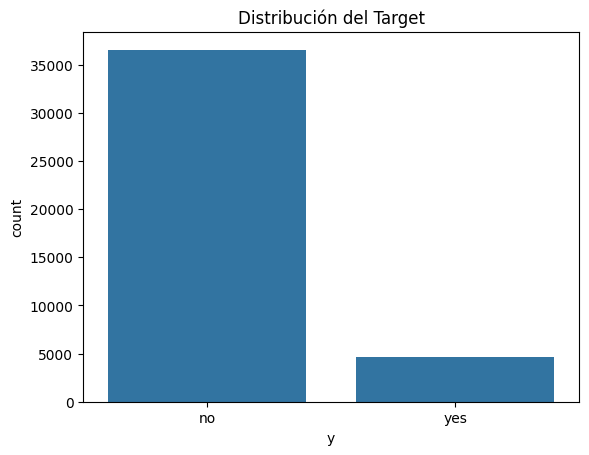

In [ ]:
df['y'].value_counts(normalize=True)
sns.countplot(x='y', data=df)
plt.title("Distribución del Target")
plt.show()

La variable "duration" solo se conoce después de la llamada, no sirve para predicción real

In [ ]:
df = df.drop(columns=['duration'])

Apartar dataset dado que contiene solo variables numericas

Analisis de Variables Numericas

Conclusiones:



***Analisis de Correlacion de Variables Numericas y Categoricas***